## Capstone Project Notebook

This notebook is the Capstone Project Notebook for __IBM data science professional certificates__

In [18]:
import pandas as pd
import numpy as np

print("Hello Capstone Project Course!")

Hello Capstone Project Course!


A description of the problem and a discussion of the background.

A description of the data and how it will be used to solve the problem.

**Prepare working environments:**

In [19]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from bs4 import BeautifulSoup
import geocoder

print('Libraries imported.')

Libraries imported.


**Data acquisition:**
1. We locate several chinatown across US on google map, acquire their lat, long, and explore venues.
2. We build a lat, long grid for the city we want to analyze, and explore venues from the grid.

Firstly, we acquire the location of 5 chinatown in US from google map, then write then into a Dataframe.

In [20]:
chinatown_sample = pd.DataFrame(columns=["City", "Latitude", "Longitude"])

# New York Chinatown
name = "New York"
lat = 40.715457
long = -73.996841
chinatown_sample = chinatown_sample.append({"City":name, 
                                            "Latitude":lat, 
                                            "Longitude":long}, 
                                            ignore_index=True)

# Chicago Chinatown
name = "Chicago"
lat = 41.850927
long = -87.634770
chinatown_sample = chinatown_sample.append({"City":name, 
                                            "Latitude":lat, 
                                            "Longitude":long}, 
                                            ignore_index=True)

# San Francisco Chinatown
name = "San Francisco"
lat = 37.794137
long = -122.406847
chinatown_sample = chinatown_sample.append({"City":name, 
                                            "Latitude":lat, 
                                            "Longitude":long}, 
                                            ignore_index=True)

# Huston Chinatown
name = "Huston"
lat = 29.703955
long = -95.546077
chinatown_sample = chinatown_sample.append({"City":name, 
                                            "Latitude":lat, 
                                            "Longitude":long}, 
                                            ignore_index=True)

# Los Angeles Chinatown
name = "Los Angeles"
lat = 34.062328
long = -118.238343
chinatown_sample = chinatown_sample.append({"City":name, 
                                            "Latitude":lat, 
                                            "Longitude":long}, 
                                            ignore_index=True)

chinatown_sample.head(5)

,City,Latitude,Longitude
0,New York,40.715457,-73.996841
1,Chicago,41.850927,-87.634770
2,San Francisco,37.794137,-122.406847
3,Huston,29.703955,-95.546077
4,Los Angeles,34.062328,-118.238343


Then we explore these areas using Foursquare API.

In [21]:
CLIENT_ID = 'WXNVVOB333ZENYKXIFMIYYQ12P3JAMYMUDQRVNACCBSDBBGZ'
CLIENT_SECRET = 'ZM3NLNWAVJVKVGUDUSYLIS4OWDMW3JIJNEYN5P5OHCOO1O5W'
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WXNVVOB333ZENYKXIFMIYYQ12P3JAMYMUDQRVNACCBSDBBGZ
CLIENT_SECRET:ZM3NLNWAVJVKVGUDUSYLIS4OWDMW3JIJNEYN5P5OHCOO1O5W


In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
chinatown_venues = getNearbyVenues(names = chinatown_sample['City'], 
                                   latitudes = chinatown_sample['Latitude'], 
                                   longitudes = chinatown_sample['Longitude'], radius = 750)
chinatown_venues.head()

,City,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New York,40.715457,-73.996841,Eye Solutions,40.714927,-73.998774,Optical Shop
1,New York,40.715457,-73.996841,Hotel 50 Bowery,40.715936,-73.996789,Hotel
2,New York,40.715457,-73.996841,Xi'an Famous Foods,40.715232,-73.997263,Chinese Restaurant
3,New York,40.715457,-73.996841,Zu Yuan Spa,40.715469,-73.998627,Spa
4,New York,40.715457,-73.996841,The Original Chinatown Ice Cream Factory,40.715521,-73.998145,Ice Cream Shop


In [24]:
chinatown_venues.groupby('City').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Chicago,66,66,66,66,66,66
Huston,66,66,66,66,66,66
Los Angeles,91,91,91,91,91,91
New York,100,100,100,100,100,100
San Francisco,100,100,100,100,100,100


Those cities are all dense enough, so it seems that there are enough venues for our feature engineering.

Next step is to select a city we want to analyze, and acquire its information. Here we take Charlotte, NC as an example.
This city has no place explicitly named "chinatown", so as someone who do not know this city at all, can I find where comfortable chinese communities exists?

In the beginning, I also try to use neighborhoods as the starting point, however, neighborhood definition differs greatly among different cities, and the information about neighborhoods cannot be acquired in a uniform way easily, which prevents us from doing it through a standard pipeling.

Therefore, here I take an alternative approach. We directly build a **latitude, longitude grids** consist of 20 * 20 points that covers the area we want to investigate. The two points to build the grid is selected manually on google map to cover most of the dense urban areas.

In [25]:
# Charlotte grids
lat_start, long_start = 35.113110, -80.965507
lat_end, long_end = 35.376885, -80.637609

sample_size = 20

grid = []

lat_step = (lat_end - lat_start)/float(sample_size)
long_step = (long_end - long_start)/float(sample_size)
for i in range(sample_size):
    for j in range(sample_size):
        grid.append([lat_start + i*lat_step, long_start + j*long_step])
        
# Plot the grid
latitude = grid[int(sample_size/2)][0]
longitude = grid[int(sample_size/2)][1]

map_grid = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, lng in grid:
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_grid)  
    
map_grid

We also build a dataframe for Charlotte.
In this grid, the distances of points is approximately 1.5 km, therefore, we use a radius = 1500 m to create a light overlap.

In [26]:
def getNearbyVenues_grid(grid, radius=1500):
    LIMIT = 200
    venues_list=[]
    index = 0
    for lat, lng in grid:
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # Only return points with more than 15 venues.
        if len(results) > 15:
            venues_list.append([(
                index, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
            index += 1

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location Index', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
grid_venues = getNearbyVenues_grid(grid, radius=1500)
grid_venues.head()

,Location Index,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,35.11311,-80.965507,Cajun Canvas,35.116538,-80.962047,General Entertainment
1,0,35.11311,-80.965507,Wing King,35.116816,-80.956874,Wings Joint
2,0,35.11311,-80.965507,A Piece of Havana,35.116673,-80.962459,Cuban Restaurant
3,0,35.11311,-80.965507,Jersey Mike's Subs,35.116783,-80.962137,Sandwich Place
4,0,35.11311,-80.965507,Papa John's Pizza,35.116785,-80.962353,Pizza Place


In [28]:
grid_venues.shape

(10041, 7)

**Exploratory data analysis:**
1. We extract features of a typical "chinese district" by ranking the venues of chinatowns.
2. We prepossess the venue data of the lat, long grids.

We firstly try to extract the features that indicate a chinese community. Here we compute the frequencies of each type of venues for the five chinatown.

In [29]:
chinatown_venue_frequency = chinatown_venues.groupby('Venue Category').count().sort_values(by = 'Venue', ascending=False)

In [90]:
chinatown_venue_frequency.head(25)

,City,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Chinese Restaurant,55,55,55,55,55,55
Bakery,19,19,19,19,19,19
Coffee Shop,14,14,14,14,14,14
Bubble Tea Shop,13,13,13,13,13,13
Vietnamese Restaurant,13,13,13,13,13,13
Asian Restaurant,12,12,12,12,12,12
Pizza Place,11,11,11,11,11,11
Mexican Restaurant,9,9,9,9,9,9
Cocktail Bar,8,8,8,8,8,8


In [31]:
grid_venues_freq = grid_venues.groupby('Venue Category').count().sort_values(by = 'Venue', ascending=False)
grid_venues_freq.head(15)

,Location Index,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Fast Food Restaurant,395,395,395,395,395,395
Pizza Place,379,379,379,379,379,379
American Restaurant,330,330,330,330,330,330
Convenience Store,325,325,325,325,325,325
Sandwich Place,296,296,296,296,296,296
Hotel,293,293,293,293,293,293
Mexican Restaurant,230,230,230,230,230,230
Discount Store,223,223,223,223,223,223
Gas Station,209,209,209,209,209,209


The general Charlotte areas have distinct venue catagories with the chinatown.

One important thing here to test is whether some of the feature is unique for chinatown. For example, Coffee Shop and Pizza Place are both frequent in chinatown, but they are also common in other areas.

We will use box plots to select the features for a chinatown.

<AxesSubplot:>

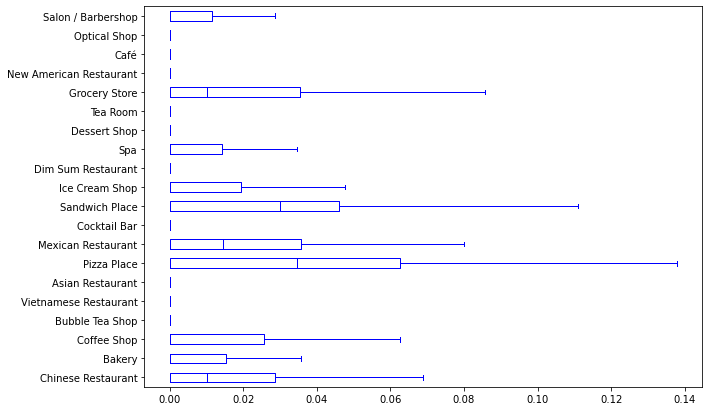

In [74]:
import seaborn as sns

grid_onehot = pd.get_dummies(grid_venues[['Venue Category']], prefix="", prefix_sep="")
grid_onehot['Location Index'] = grid_venues['Location Index'] 
fixed_columns = [grid_onehot.columns[-1]] + list(grid_onehot.columns[:-1])
grid_onehot = grid_onehot[fixed_columns]
grid_grouped = grid_onehot.groupby('Location Index').mean().reset_index()
feature_list = list(chinatown_venue_frequency.index)[0:20]
grid_grouped[feature_list].plot(kind='box', figsize=(10, 7), color='blue', vert=False, showfliers=False)
#df_CI.plot(kind='box', figsize=(10, 7), color='blue', vert=False)

This is the box plot of feature frequencies concerning 400 charlotte grid areas. We then check the chinatown data:

In [89]:
chinatown_onehot = pd.get_dummies(chinatown_venues[['Venue Category']], prefix="", prefix_sep="")
chinatown_onehot['City'] = chinatown_venues['City'] 
fixed_columns = [chinatown_onehot.columns[-1]] + list(chinatown_onehot.columns[:-1])
chinatown_onehot = chinatown_onehot[fixed_columns]
chinatown_grouped = chinatown_onehot.groupby('City').mean().reset_index()
feature_list = list(chinatown_venue_frequency.index)[0:20]
chinatown_averaged = chinatown_grouped[feature_list].mean(axis = 0)
chinatown_averaged.head(20)

Chinese Restaurant         0.142252
Bakery                     0.044973
Coffee Shop                0.028989
Bubble Tea Shop            0.035471
Vietnamese Restaurant      0.033369
Asian Restaurant           0.033273
Pizza Place                0.025487
Mexican Restaurant         0.020613
Cocktail Bar               0.016000
Sandwich Place             0.016791
Ice Cream Shop             0.018258
Dim Sum Restaurant         0.020517
Spa                        0.017426
Dessert Shop               0.021152
Tea Room                   0.018258
Grocery Store              0.018319
New American Restaurant    0.012198
Café                       0.011228
Optical Shop               0.010000
Salon / Barbershop         0.011030
dtype: float64

So, we can determine what we should keep as a chinatown feature and what should we abandon.

For example, Bakery have an average frequency of 0.044973, higher than the 1.5 IQR of 400 average indices. Therefore, Bakery frequency is a valid feature. While Coffee Shop (0.028989) is inside 1.5 IQR, therefore, it should be removed from a chinatown feature sets.

Finally, we exclude Coffee Shop, Pizza Place, Mexican Restaurant, Sandwich Place, Ice Cream Shop, Spa, Grocery Store, Salon / Barbershop from the sets.

**Method tests**

In [278]:
# Unsupervised approach
def chi_features(string):
    return "China_features"

chinatown_venues_index = chinatown_venues.rename(columns={'City': 'Location Index'})
chinatown_venues_index['Location Index'] = chinatown_venues_index['Location Index'].apply(chi_features)
chinatown_venues_index.groupby('Venue Category').count().sort_values(by = 'Venue', ascending=False).head(15)

,Location Index,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Chinese Restaurant,57,57,57,57,57,57
Vietnamese Restaurant,13,13,13,13,13,13
Asian Restaurant,12,12,12,12,12,12
Bubble Tea Shop,12,12,12,12,12,12
Dessert Shop,10,10,10,10,10,10
Dim Sum Restaurant,8,8,8,8,8,8
Tea Room,8,8,8,8,8,8
Korean Restaurant,6,6,6,6,6,6
Spa,6,6,6,6,6,6


In [124]:
total_venues = pd.concat([grid_venues, chinatown_venues_index])
total_venues.tail(5)

,Location Index,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
420,China_features,34.062328,-118.238343,Ford and Ching,34.063785,-118.245272,Furniture / Home Store
422,China_features,34.062328,-118.238343,Bristol Farms,34.064819,-118.244980,Farmers Market
423,China_features,34.062328,-118.238343,Fire House #1,34.056007,-118.238847,Museum
424,China_features,34.062328,-118.238343,Top Secret Place,34.065629,-118.245063,Nightlife Spot
425,China_features,34.062328,-118.238343,The Orsini Karaoke Room,34.061330,-118.246190,Karaoke Bar


In [125]:
total_onehot = pd.get_dummies(total_venues[['Venue Category']], prefix="", prefix_sep="")
total_onehot['Location Index'] = total_venues['Location Index'] 
fixed_columns = [total_onehot.columns[-1]] + list(total_onehot.columns[:-1])
total_onehot = total_onehot[fixed_columns]
total_grouped = total_onehot.groupby('Location Index').mean().reset_index()
total_grouped.shape

(104, 328)

In [126]:
total_grouped.tail()

,Location Index,ATM,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Big Box Store,Bike Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,College Bookstore,College Football Field,College Gym,College Library,College Rec Center,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Motorsports Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Optical Shop,Outdoors & Recreation,Outlet Mall,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Parking,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Picnic Area,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Post Office,Pub,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residence,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sausage Shop,Scandinavian Restaurant,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,South Indian Restaurant,Southern / Soul Food Re

In [129]:
total_indices = total_venues[['Location Index', 'Latitude', 'Longitude']].drop_duplicates(subset=['Location Index']).reset_index().drop('index', 1)
total_indices.tail()

,Location Index,Latitude,Longitude
99,99,35.363696,-80.785163
100,100,35.363696,-80.719583
101,101,35.363696,-80.703189
102,102,35.363696,-80.670399
103,China_features,40.715457,-73.996841


In [130]:
from sklearn.cluster import KMeans

kclusters = 8
total_grouped_clustering = total_grouped.drop('Location Index', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(total_grouped_clustering)

total_indices.insert(0, 'Cluster Labels', kmeans.labels_)
total_indices

,Cluster Labels,Location Index,Latitude,Longitude
0,2,0,35.113110,-80.883533
1,2,1,35.113110,-80.850743
2,2,2,35.113110,-80.817953
3,1,3,35.113110,-80.719583
4,0,4,35.113110,-80.703189
5,1,5,35.126299,-80.949112
6,1,6,35.126299,-80.735978
7,2,7,35.126299,-80.703189
8,2,8,35.126299,-80.654004
9,2,9,35.139488,-80.932717


In [131]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(total_indices['Latitude'], total_indices['Longitude'], total_indices['Location Index'], total_indices['Cluster Labels']):
    if poi == "China_features": break
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

All blue clueters are in the same cluster of the five chinatowm. Therefore, the naive clustering cannot distinguish chinese districts with other areas, since their venue types are too similar.

One solution to this situation is to **weight the feature** based on chinatown venue frequencies to enhance the importance of those venues, so they got more attention during clustering.

In [292]:
# Acquire weights
A = chinatown_venue_frequency['City'].sum()
S = chinatown_venue_frequency['City'].apply(lambda x: x/A)
S = S.drop('Coffee Shop')
S = S.drop('Pizza Place')
S = S.drop('Mexican Restaurant')
S = S.drop('Sandwich Place')
S = S.drop('Ice Cream Shop')
S = S.drop('Spa')
S = S.drop('Grocery Store')
S = S.drop('Salon / Barbershop')
S[0:5]

Venue Category
Chinese Restaurant       0.133803
Bakery                   0.042254
Vietnamese Restaurant    0.030516
Asian Restaurant         0.028169
Bubble Tea Shop          0.028169
Name: City, dtype: float64

In [293]:
chinatown_onehot = pd.get_dummies(chinatown_venues[['Venue Category']], prefix="", prefix_sep="")
chinatown_onehot['City'] = chinatown_venues['City'] 
fixed_columns = [chinatown_onehot.columns[-1]] + list(chinatown_onehot.columns[:-1])
chinatown_onehot = chinatown_onehot[fixed_columns]
chinatown_grouped = chinatown_onehot.groupby('City').mean().reset_index()
chinatown_grouped.head()

,City,American Restaurant,Animal Shelter,Art Gallery,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beer Garden,Beijing Restaurant,Bike Shop,Boat or Ferry,Bookstore,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Cosmetics Shop,Deli / Bodega,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flower Shop,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Health & Beauty Service,High School,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Hunan Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Liquor Store,Lounge,Malay Restaurant,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Mobile Phone Shop,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Optical Shop,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pharmacy,Pizza Place,Platform,Playground,Plaza,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rock Club,Roof Deck,Russian Restaurant,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shopping Mall,Snack Place,South American Restaurant,Spa,Spanish Restaurant,Sports Club,Storage Facility,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tea Room,Thai Restaurant,Train Station,Travel Lounge,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Xinjiang Restaurant,Yoga Studio
0,Chicago,0.00,0.00,0.000000,0.058824,0.00,0.014706,0.029412,0.000000,0.000000,0.014706,0.000000,0.00,0.014706,0.00,0.000000,0.014706,0.000000,0.00,0.000000,0.000000,0.000000,0.014706,0.014706,0.00,0.279412,0.00,0.00,0.000000,0.014706,0.00,0.00,0.044118,0.029412,0.000000,0.000000,0.000000,0.014706,0.000000,0.00,0.014706,0.00,0.014706,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.029412,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.014706,0.00,0.014706,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.014706,0.000000,0.00,0.044118,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.014706,0.014706,0.000000,0.00,0.00,0.000000,0.014706,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.029412,0.029412,0.00,0.014706,0.014706,0.014706,0.000000,0.000000,0.00,0.014706,0.00,0.00,0.014706,0.000000,0.014706,0.014706,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.029412,0.000000,0.000000,0.000000,0.000000,0.014706,0.014706,0.000000,0.029412,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.00
1,Huston,0.00,0.00,0.000000,0.073529,0.00,0.000000,0.044118,0.029412,0.000000,0.000000,0.014706,0.00,0.000000,0.00,0.000000,0.102941,0.000000,0.00,0.000000,0.014706,0.000000,0.000000,0.000000,0.00,0.176471,0.00,0.00,0.014706,0.000000,0.00,0.00,0.058824,0.014706,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.029412,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.014706,0.014706,0.029412,0.00,0.00,0.000000,0.000000,0.00,0.029412,0.00,0.000000,0.000000,0.00,0.044118,0.00,0.000000,0.029412,0.00,0.014706,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.014706,0.000000,0.00,0.000000,0.014706,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.014706,0.00,0.014706,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.014706,0.014706,0.014706,0.000000,0.014706,0.014706,0.000000,0.000000,0.000000,0.00,0.

In [294]:
grid_onehot = pd.get_dummies(grid_venues[['Venue Category']], prefix="", prefix_sep="")
grid_onehot['Location Index'] = grid_venues['Location Index'] 
fixed_columns = [grid_onehot.columns[-1]] + list(grid_onehot.columns[:-1])
grid_onehot = grid_onehot[fixed_columns]
grid_grouped = grid_onehot.groupby('Location Index').mean().reset_index()
grid_grouped.head()

,Location Index,ATM,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Bookstore,College Communications Building,College Football Field,College Gym,College Library,College Rec Center,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Fabric Shop,Factory,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hot Dog Joint,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Mongolian Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Night Market,Nightclub,Noodle House,Office,Optical Shop,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Outlet Mall,Outlet Store,Paper / Office Supplies Store,Park,Parking,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Post Office,Print Shop,Pub,Racetrack,Real Estate Office,Record Shop,Recreation Center,Rental Car Location,Rental Service,Residence,Residential Building (Apartment / Condo),Rest Area,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski

In [295]:
from sklearn.cluster import KMeans

# Apply the weights and truncate the table
grid_grouped_weighted = grid_grouped.multiply(S).fillna(0.0)
col_list = list(chinatown_grouped.rename(columns={'City': 'Location Index'}))
grid_grouped_weighted = grid_grouped_weighted[col_list]

grid_indices = grid_venues[['Location Index', 'Latitude', 'Longitude']].drop_duplicates(subset=['Location Index']).reset_index().drop('index', 1)
grid_indices.tail()

kclusters = 8
grid_grouped_clustering = grid_grouped_weighted.drop('Location Index', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grid_grouped_clustering)

grid_indices.insert(0, 'Cluster Labels', kmeans.labels_)
grid_indices.head()

,Cluster Labels,Location Index,Latitude,Longitude
0,1,0,35.11311,-80.965507
1,1,1,35.11311,-80.949112
2,7,2,35.11311,-80.932717
3,6,3,35.11311,-80.916322
4,6,4,35.11311,-80.883533


In [296]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(grid_indices['Latitude'], grid_indices['Longitude'], grid_indices['Location Index'], grid_indices['Cluster Labels']):
    if poi == "China_features": break
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [298]:
grid_grouped_labeled = grid_grouped_weighted
grid_grouped_labeled['Score'] = grid_grouped_labeled.sum(axis = 1)
grid_grouped_labeled.insert(0, 'Cluster Labels', kmeans.labels_)
grid_grouped_score = grid_grouped_labeled.groupby('Cluster Labels').mean()['Score']
grid_grouped_score

Cluster Labels
0    0.005412
1    0.008244
2    0.014474
3    0.009552
4    0.006132
5    0.004201
6    0.003496
7    0.006727
Name: Score, dtype: float64

In [299]:
A = list(zip(list(grid_grouped_score), range(8)))
A.sort(reverse=True)
print(A)

[(0.014473768293615482, 2), (0.009552473598868854, 3), (0.008244248346374519, 1), (0.006726888480804591, 7), (0.006131563185375382, 4), (0.005411851289904096, 0), (0.004200835817840373, 5), (0.0034957420320125684, 6)]


In [300]:
# recolor the map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(grid_indices['Latitude'], grid_indices['Longitude'], grid_indices['Location Index'], grid_indices['Cluster Labels']):
    if poi == "China_features": break
    if cluster == A[4][1] or cluster == A[5][1] or cluster == A[6][1] or cluster == A[7][1]: continue
    color_d = 'white'
    if cluster == A[0][1]: color_d = 'darkred'
    if cluster == A[1][1]: color_d = 'red'
    if cluster == A[2][1]: color_d = 'pink'
    if cluster == A[3][1]: color_d = 'white'
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color_d,
        fill=True,
        fill_color=color_d,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The second example: Atlanta

In [258]:
# Atlanta grids
lat_start, long_start = 33.620260, -84.543165
lat_end, long_end = 34.024354, -84.112095

sample_size = 20

grid = []

lat_step = (lat_end - lat_start)/float(sample_size)
long_step = (long_end - long_start)/float(sample_size)
for i in range(sample_size):
    for j in range(sample_size):
        grid.append([lat_start + i*lat_step, long_start + j*long_step])
        
# Plot the grid
latitude = grid[int(sample_size/2)][0]
longitude = grid[int(sample_size/2)][1]

map_grid = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, lng in grid:
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_grid)  
    
map_grid

In [262]:
grid_venues_2 = getNearbyVenues_grid(grid, radius=1500)
grid_venues_2.head()

,Location Index,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,33.62026,-84.478504,College Park Crab Pot,33.615771,-84.476075,Seafood Restaurant
1,0,33.62026,-84.478504,Tropical Cuisine,33.622083,-84.476598,Caribbean Restaurant
2,0,33.62026,-84.478504,Cozumel The Mexican Cantina,33.617599,-84.472282,Mexican Restaurant
3,0,33.62026,-84.478504,Subway,33.618422,-84.473223,Sandwich Place
4,0,33.62026,-84.478504,Circle K,33.622084,-84.474906,Convenience Store


In [288]:
from sklearn.cluster import KMeans

A = chinatown_venue_frequency['City'].sum()
S = chinatown_venue_frequency['City'].apply(lambda x: x/A)
S = S.drop('Coffee Shop')
S = S.drop('Pizza Place')
S = S.drop('Mexican Restaurant')
S = S.drop('Sandwich Place')
S = S.drop('Ice Cream Shop')
S = S.drop('Spa')
S = S.drop('Grocery Store')
S = S.drop('Salon / Barbershop')

grid_onehot_2 = pd.get_dummies(grid_venues_2[['Venue Category']], prefix="", prefix_sep="")
grid_onehot_2['Location Index'] = grid_venues_2['Location Index'] 
fixed_columns = [grid_onehot_2.columns[-1]] + list(grid_onehot_2.columns[:-1])
grid_onehot_2 = grid_onehot_2[fixed_columns]
grid_grouped_2 = grid_onehot_2.groupby('Location Index').mean().reset_index()
#grid_grouped_2.head()

grid_grouped_weighted_2 = grid_grouped_2.multiply(S).fillna(0.0)
col_list = list(chinatown_grouped.rename(columns={'City': 'Location Index'}))
grid_grouped_weighted_2 = grid_grouped_weighted_2[col_list]

grid_indices_2 = grid_venues_2[['Location Index', 'Latitude', 'Longitude']].drop_duplicates(subset=['Location Index']).reset_index().drop('index', 1)
#grid_indices_2.tail()

kclusters = 8
grid_grouped_clustering_2 = grid_grouped_weighted_2.drop('Location Index', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grid_grouped_clustering_2)

grid_indices_2.insert(0, 'Cluster Labels', kmeans.labels_)
grid_indices_2.head()

,Cluster Labels,Location Index,Latitude,Longitude
0,4,0,33.62026,-84.478504
1,4,1,33.62026,-84.456951
2,4,2,33.62026,-84.435397
3,4,3,33.62026,-84.392291
4,4,4,33.62026,-84.370737


In [289]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(grid_indices_2['Latitude'], grid_indices_2['Longitude'], grid_indices_2['Location Index'], grid_indices_2['Cluster Labels']):
    if poi == "China_features": break
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [290]:
grid_grouped_labeled_2 = grid_grouped_weighted_2
grid_grouped_labeled_2['Score'] = grid_grouped_labeled_2.sum(axis = 1)
grid_grouped_labeled_2.insert(0, 'Cluster Labels', kmeans.labels_)
grid_grouped_score_2 = grid_grouped_labeled_2.groupby('Cluster Labels').mean()['Score']
#grid_grouped_score_2
A = list(zip(list(grid_grouped_score_2), range(8)))
A.sort(reverse=True)
print(A)

[(0.024754588134869825, 6), (0.01390295384264501, 2), (0.010004327086305066, 7), (0.00847502975389695, 1), (0.006649562136008808, 5), (0.006238722647557756, 3), (0.004131218684227968, 0), (0.002880182915829941, 4)]


In [291]:
# recolor the map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(grid_indices_2['Latitude'], grid_indices_2['Longitude'], grid_indices_2['Location Index'], grid_indices_2['Cluster Labels']):
    if poi == "China_features": break
    if cluster == A[4][1] or cluster == A[5][1] or cluster == A[6][1] or cluster == A[7][1]: continue
    color_d = 'white'
    if cluster == A[0][1]: color_d = 'darkred'
    if cluster == A[1][1]: color_d = 'red'
    if cluster == A[2][1]: color_d = 'pink'
    if cluster == A[3][1]: color_d = 'white'
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color_d,
        fill=True,
        fill_color=color_d,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Deployment**

Finally we collect our codes into a function:

In [91]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from bs4 import BeautifulSoup
import geocoder
from sklearn.cluster import KMeans

print('libraries imported!')
CLIENT_ID = 'WXNVVOB333ZENYKXIFMIYYQ12P3JAMYMUDQRVNACCBSDBBGZ'
CLIENT_SECRET = 'ZM3NLNWAVJVKVGUDUSYLIS4OWDMW3JIJNEYN5P5OHCOO1O5W'
VERSION = '20180605'
LIMIT = 200

def getNearbyVenues_grid(grid, radius=1500):
    LIMIT = 200
    venues_list=[]
    index = 0
    for lat, lng in grid:
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # Only return points with more than 15 venues.
        if len(results) > 15:
            venues_list.append([(
                index, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
            index += 1

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location Index', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def build_chinatown_venues():
    chinatown_sample = pd.DataFrame(columns=["City", "Latitude", "Longitude"])

    # New York Chinatown
    name = "New York"
    lat = 40.715457
    long = -73.996841
    chinatown_sample = chinatown_sample.append({"City":name, 
                                                "Latitude":lat, 
                                                "Longitude":long}, 
                                                ignore_index=True)

    # Chicago Chinatown
    name = "Chicago"
    lat = 41.850927
    long = -87.634770
    chinatown_sample = chinatown_sample.append({"City":name, 
                                                "Latitude":lat, 
                                                "Longitude":long}, 
                                                ignore_index=True)

    # San Francisco Chinatown
    name = "San Francisco"
    lat = 37.794137
    long = -122.406847
    chinatown_sample = chinatown_sample.append({"City":name, 
                                                "Latitude":lat, 
                                                "Longitude":long}, 
                                                ignore_index=True)

    # Huston Chinatown
    name = "Huston"
    lat = 29.703955
    long = -95.546077
    chinatown_sample = chinatown_sample.append({"City":name, 
                                                "Latitude":lat, 
                                                "Longitude":long}, 
                                                ignore_index=True)

    # Los Angeles Chinatown
    name = "Los Angeles"
    lat = 34.062328
    long = -118.238343
    chinatown_sample = chinatown_sample.append({"City":name, 
                                                "Latitude":lat, 
                                                "Longitude":long}, 
                                                ignore_index=True)
    
    chinatown_venues = getNearbyVenues(names = chinatown_sample['City'], 
                                   latitudes = chinatown_sample['Latitude'], 
                                   longitudes = chinatown_sample['Longitude'], radius = 750)
    return chinatown_venues

def find_chinese_district(lat_range, long_range, sample_size):
    print('Building grids ...')
    lat_start, long_start = lat_range[0], long_range[0]
    lat_end, long_end = lat_range[1], long_range[1]
    grid = []
    lat_step = (lat_end - lat_start)/float(sample_size)
    long_step = (long_end - long_start)/float(sample_size)
    for i in range(sample_size):
        for j in range(sample_size):
            grid.append([lat_start + i*lat_step, long_start + j*long_step])
    latitude = grid[int(sample_size/2)][0]
    longitude = grid[int(sample_size/2)][1]
    
    print('Acquiring venue data from Foursquare ...')
    grid_venues_2 = getNearbyVenues_grid(grid, radius=1500)
    print('Venue data acquired!')
    
    print('Building chinatown features ...')
    chinatown_venues = build_chinatown_venues()
    chinatown_venue_frequency = chinatown_venues.groupby('Venue Category').count().sort_values(by = 'Venue', ascending=False)
    chinatown_onehot = pd.get_dummies(chinatown_venues[['Venue Category']], prefix="", prefix_sep="")
    chinatown_onehot['City'] = chinatown_venues['City'] 
    fixed_columns = [chinatown_onehot.columns[-1]] + list(chinatown_onehot.columns[:-1])
    chinatown_onehot = chinatown_onehot[fixed_columns]
    chinatown_grouped = chinatown_onehot.groupby('City').mean().reset_index()
    
    print('Selecting and encoding features ...')
    A = chinatown_venue_frequency['City'].sum()
    S = chinatown_venue_frequency['City'].apply(lambda x: x/A)
    S = S.drop('Coffee Shop')
    S = S.drop('Pizza Place')
    S = S.drop('Mexican Restaurant')
    S = S.drop('Sandwich Place')
    S = S.drop('Ice Cream Shop')
    S = S.drop('Spa')
    S = S.drop('Grocery Store')
    S = S.drop('Salon / Barbershop')
    
    grid_onehot_2 = pd.get_dummies(grid_venues_2[['Venue Category']], prefix="", prefix_sep="")
    grid_onehot_2['Location Index'] = grid_venues_2['Location Index'] 
    fixed_columns = [grid_onehot_2.columns[-1]] + list(grid_onehot_2.columns[:-1])
    grid_onehot_2 = grid_onehot_2[fixed_columns]
    grid_grouped_2 = grid_onehot_2.groupby('Location Index').mean().reset_index()

    grid_grouped_weighted_2 = grid_grouped_2.multiply(S).fillna(0.0)
    col_list = list(chinatown_grouped.rename(columns={'City': 'Location Index'}))
    grid_grouped_weighted_2 = grid_grouped_weighted_2[col_list]

    grid_indices_2 = grid_venues_2[['Location Index', 'Latitude', 'Longitude']].drop_duplicates(subset=['Location Index']).reset_index().drop('index', 1)
    
    print('Run clustering ...')
    kclusters = 8
    if len(grid_grouped_weighted_2) < 8:
        kclusters = int(len(grid_grouped_weighted_2)/2) + 1
    if kclusters < 3:
        print("Too few number of samples! Please increase sample_size!")
        return None
    grid_grouped_clustering_2 = grid_grouped_weighted_2.drop('Location Index', 1)
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grid_grouped_clustering_2)
    
    grid_indices_2.insert(0, 'Cluster Labels', kmeans.labels_)
    grid_grouped_labeled_2 = grid_grouped_weighted_2
    grid_grouped_labeled_2['Score'] = grid_grouped_labeled_2.sum(axis = 1)
    grid_grouped_labeled_2.insert(0, 'Cluster Labels', kmeans.labels_)
    grid_grouped_score_2 = grid_grouped_labeled_2.groupby('Cluster Labels').mean()['Score']
    A = list(zip(list(grid_grouped_score_2), range(8)))
    A.sort(reverse=True)
    print('Done ...')
    
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
    
    markers_colors = []
    for lat, lon, poi, cluster in zip(grid_indices_2['Latitude'], grid_indices_2['Longitude'], grid_indices_2['Location Index'], grid_indices_2['Cluster Labels']):
        if poi == "China_features": break
        #if cluster != A[0][1] and cluster != A[1][1] and cluster != A[2][1] and cluster != A[3][1]: continue
        color_d = 'white'
        if cluster == A[0][1]: color_d = 'darkred'
        if cluster == A[1][1]: color_d = 'red'
        if cluster == A[2][1]: color_d = 'pink'
        #if cluster == A[3][1]: color_d = 'white'
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=color_d,
            fill=True,
            fill_color=color_d,
            fill_opacity=0.7).add_to(map_clusters)
       
    return map_clusters

libraries imported!


In [92]:
lat = [33.620260, 34.024354]
long = [-84.543165, -84.112095]
sample = 20
find_chinese_district(lat, long, sample)

Building grids ...
Acquiring venue data from Foursquare ...
Venue data acquired!
Building chinatown features ...
Selecting and encoding features ...
Run clustering ...
Done ...


NameError: name 'grid_grouped_weighted_2' is not defined